# FigureFluoremaxbeads 2024

## Imports

In [1]:
import matplotlib.font_manager
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

In [2]:
import matplotlib.pyplot as plt
from cleanplots import *

import numpy as np
import torch
import torchvision
import os
import sys
sys.path.append("../") # needed to bring in sdc module
import sdc_config5 as sdc
import jax.numpy as jnp
import jax
from scipy.signal import savgol_filter

# figures helper functions
%run figures_util.py

# stop jax from taking over gpu memory
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## System parameters

In [19]:
wvmin = 450
wvmax = 800
wvstep = 8
downsample_factor = 1
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)
objective = 4 # 4x objective
mag_size = objective*9/39 # 4x followed by diffuser F=9mm and relay lens f=39mm
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor # 2x2 downsampling
gt_pixel_size = 1.25 # um # empirically calculated based on 10 micron bead image
gt_mag_size = objective*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um


## Plot recon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7903192440611195].


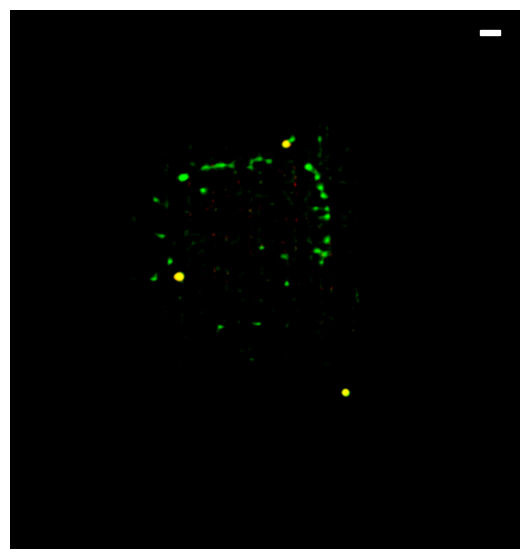

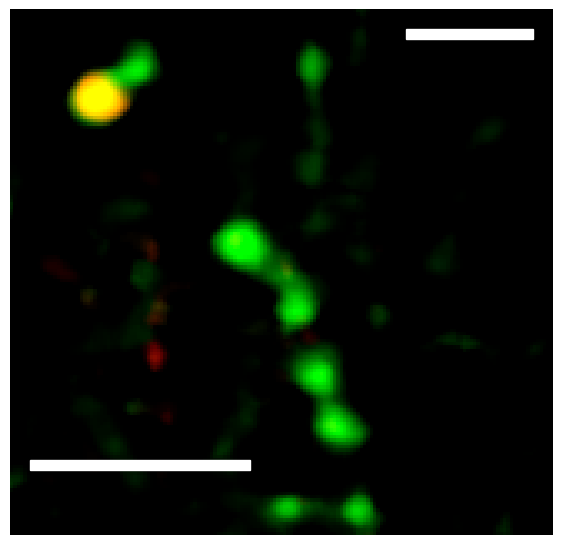

In [17]:
datafolder = '../Results'
file = 'fluoro_beads_noLR4k_noDownSample_step0.025_thr6e-04_lam2e-06.npy'

xk = np.load(os.path.join(datafolder, file))
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)

# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(false_color**1.8*2)
plt.axis('off')
# ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'upper right')
ax.add_artist(scalebarum)


false_color_zoom = false_color[230:388, 502:665,:]
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(false_color_zoom**1.8*2)
plt.axis('off')
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'upper right', size_vertical=3)
ax.add_artist(scalebarum)
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size, scalebarname='', size_vertical=3, loc = 'lower left')
ax.add_artist(scalebar)


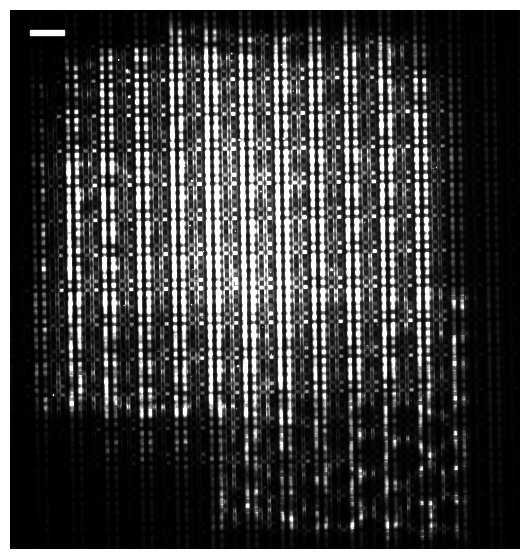

In [5]:
#top bottom left right
crop_indices = [620,1652,1350,2326] 
datafolder = '/media/azuldata/neerja/2024-04-22_huvec_patterned/fluoro_beads'
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'

bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement, cmap='gray')
# plt.colorbar()  
plt.clim([0,.1])
plt.axis('off')

scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size, scalebarname='')
ax.add_artist(scalebar)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1140922e-17..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7609989e-17..1.0].


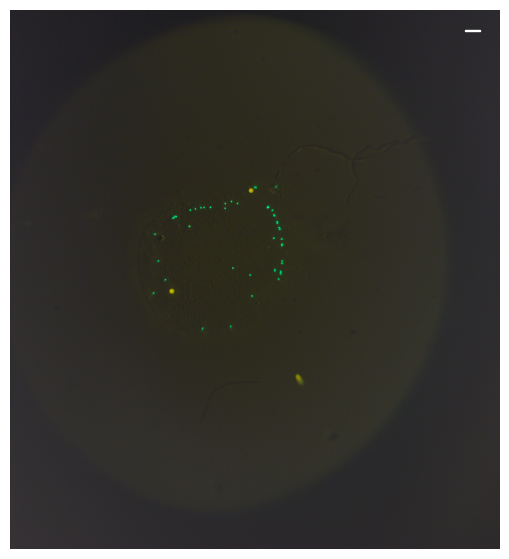

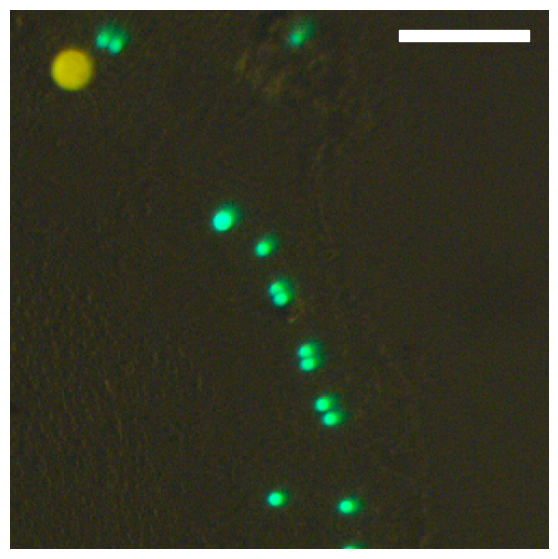

In [6]:
# draw groundtruth
gt_name = 'gt.tiff'

# load sample and background both located in datafolder
gt = sdc.importTiff(datafolder,gt_name)/2**bits
gt = gt/torch.max(gt)

import scipy.ndimage as ndimage

# Rotate the image without zero-padding
gt_rot = ndimage.rotate(gt, -90, reshape=True)

fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_rot)
plt.axis('off')
scalebar = drawscalebar(ax, 100,gt_pixel_size,mag = gt_mag_size, scalebarname='', loc = 'upper right')
ax.add_artist(scalebar)

# plot zoom in
gt_zoom = gt_rot[1455:1955, 1958:2458]
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_zoom)
plt.axis('off')
scalebar = drawscalebar(ax, 100,gt_pixel_size,mag = gt_mag_size, scalebarname='', loc = 'upper right')
ax.add_artist(scalebar)


## plot bead spectra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7072845035830482].


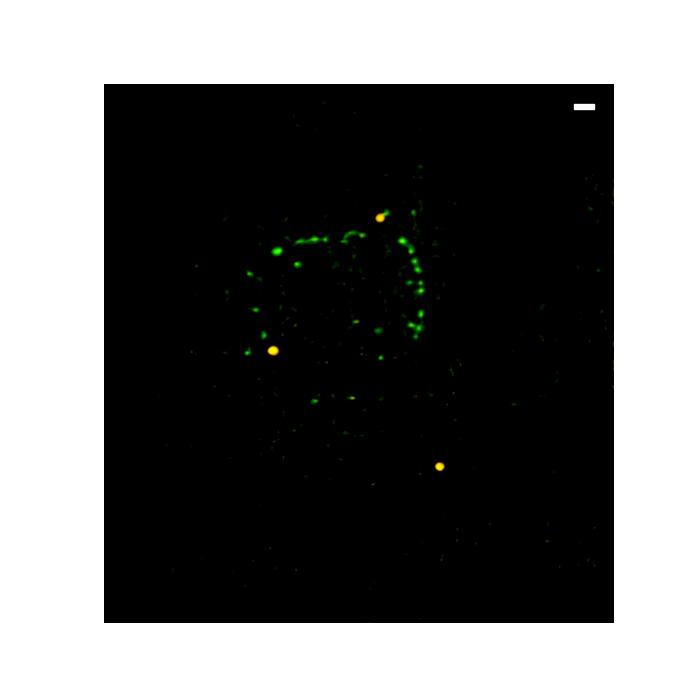

In [26]:
%matplotlib widget
# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(false_color**1.8*2)
plt.axis('off')
# ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='', loc = 'upper right')
ax.add_artist(scalebarum)

## Import ground truth spectra

['#Thorlabs FTS']
['#Thorlabs FTS']
1207
450.0450134
2302
699.9939575


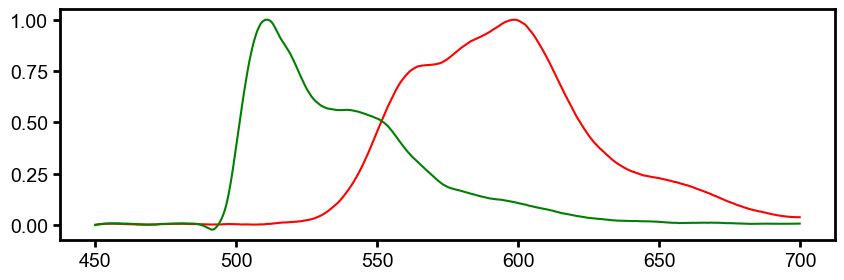

In [7]:
#import ground truth spectra 

green_beads = '/media/azuldata/neerja/2022-04-08/greenbeads_oldslide_emissionspectra.csv'
red_beads = '/media/azuldata/neerja/2022-04-08/redbeads_fresh_emissionspectra.csv'
import csv
file = open(green_beads)
csvreader = csv.reader(file)
header = next(csvreader)
print(header)
rows = []
for row in csvreader:
#     print(row)
    rows.append(row)
file.close()
green_spec = rows[32:-1]
g_wavelength = []
g_intensity = []
for ii in green_spec:
    vals = ii[0].split(';')
    g_wavelength.append(float(vals[0]))
    g_intensity.append(float(vals[1]))

file = open(red_beads)
csvreader = csv.reader(file)
header = next(csvreader)
print(header)
rows = []
for row in csvreader:
#     print(row)
    rows.append(row)
file.close()
green_spec = rows[32:-1]
r_wavelength = []
r_intensity = []
for ii in green_spec:
    vals = ii[0].split(';')
    r_wavelength.append(float(vals[0]))
    r_intensity.append(float(vals[1]))

    # cut to wvnew and filter and normalize
from scipy.signal import savgol_filter

rwv = np.array(r_wavelength)
idxmin = np.where(abs(rwv-wvmin) == np.amin(abs(rwv-wvmin)))[0][0]
idxmax = np.where(abs(rwv-wvmax) == np.amin(abs(rwv-wvmax)))[0][0]
print(idxmin)
print(rwv[idxmin])
print(idxmax)
print(rwv[idxmax])

rwvn = rwv[idxmin:idxmax]
rint = np.array(r_intensity)
rintn = savgol_filter(rint[idxmin:idxmax],91,3) #cut and filter
rintn = rintn/np.amax(rintn)

gwv = np.array(g_wavelength)
gint = np.array(g_intensity)
gwvn = gwv[idxmin:idxmax]
gintn = savgol_filter(gint[idxmin:idxmax],91,3) #cut and filter
gintn = gintn/np.amax(gintn)

plt.figure(figsize = (10,3))
plt.plot(rwvn,rintn,'r')
plt.plot(gwvn,gintn,'g')

## Plot spectra

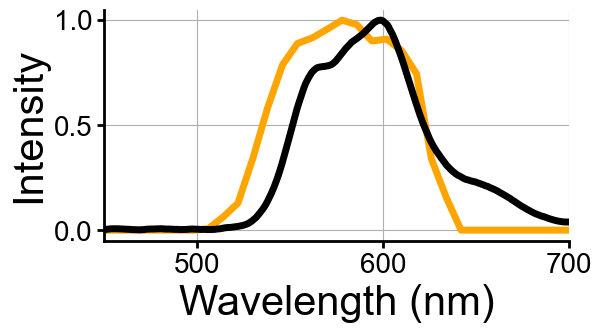

In [21]:
bead1 = [256,528]
bead2 = [248,540]

pix_avg = 1

spec = xk[:,bead1[0]-pix_avg:bead1[0]+pix_avg,bead1[1]-pix_avg:bead1[1]+pix_avg]
spec = np.mean(spec, axis = (1,2))
orange_bead = spec/np.max(spec)
# spec_fil = savgol_filter(spec,10,3)
# orange_bead_fil = spec_fil/np.max(spec_fil)    

plt.figure(figsize = (6,3))
plt.plot(wavelengths, orange_bead, color='orange', linewidth=5)
# plt.plot(wavelengths, orange_bead_fil, color='orange', linewidth=5)

plt.xlabel('Wavelength (nm)', fontsize=30)
plt.ylabel('Intensity', fontsize=30)
plt.xticks([500,600,700],fontsize=20)
plt.yticks([0,0.5,1], fontsize=20)
plt.xlim([450,700])
plt.plot(rwvn,rintn,'k', linewidth=5)
plt.grid(True)

# plt.plot(wavelengths_gt, spectra_gt[:,1],'k',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

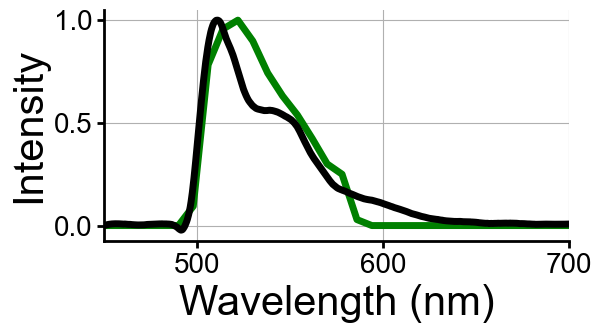

In [23]:
spec = xk[:,bead2[0]-pix_avg:bead2[0]+pix_avg,bead2[1]-pix_avg:bead2[1]+pix_avg]
spec = np.mean(spec, axis = (1,2))
green_bead = spec/np.max(spec)
# spec_fil = savgol_filter(spec,10,3)
# green_bead_fil = spec_fil/np.max(spec_fil)    

plt.figure(figsize = (6,3))
plt.plot(wavelengths, green_bead, color='green', linewidth=5)
# plt.plot(wavelengths, green_bead_fil, color='green', linewidth=5)

plt.xlabel('Wavelength (nm)', fontsize=30)
plt.ylabel('Intensity', fontsize=30)
plt.xticks([500,600,700],fontsize=20)
plt.yticks([0,0.5,1], fontsize=20)
plt.xlim([450,700])
plt.grid('True')
plt.plot(gwvn,gintn,'k', linewidth=5)
# plt.plot(wavelengths_gt, spectra_gt[:,1],'k',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## try on newer data